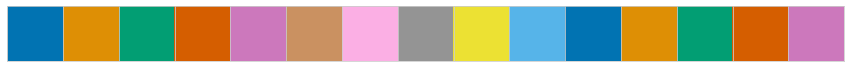

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import sys
import geopandas as gpd
import datetime as dt
import csv

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
fig_format = "png"
dpi = 600
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

path_data = r"D:\Cardiff University\National Grid Project - General\Paper\data for UKERC"

## To remove warnings
import warnings
warnings.filterwarnings('ignore')



In [2]:
def create_map(df, target, path_map, fig, ax, cmap=None, percentage_scale=False):
    
    map_df = gpd.read_file(path_map)
    map_df.crs = {'init': 'epsg:4326'}
    
    map_df = pd.merge(map_df, df[['LSOA11CD', target]], left_on="GeographyCode", right_on="LSOA11CD", how="left")
    map_df = map_df.dropna(subset=[target])

    # create figure and axes for Matplotlib
    if percentage_scale:
        vmin = 0
        vmax = 1
    else:
        vmin=0
        vmax=map_df[target].max()

    
    ax.axis('off')
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    
    map_df = map_df.to_crs({'init': 'epsg:3395'}) # mercator projections
    
    if cmap==None:
        cmap='Blues'
        
    map_df.plot(column=target, cmap=cmap, linewidth=0.01, ax=ax,  edgecolor='black', vmin=vmin, vmax=vmax) #,

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    
    plt.close()
    return cbar


# Example of usage of the database available for download at: https://doi.org/10.5286/ukerc.edc.000944

# Dataset 1

In [3]:
dataset1_fn = "Annual_heat_demand_LSOA.csv"

dataset1 = pd.read_csv(path_data+os.path.sep+dataset1_fn, low_memory=False)

dataset2_fn = "Energy_efficiency_improvements_costs_LA.csv"

dataset2 = pd.read_csv(path_data+os.path.sep+dataset2_fn, low_memory=False)

dataset3_fn = "Half-hourly_profiles_of_heating_technologies.csv"

dataset3 = pd.read_csv(path_data+os.path.sep+dataset3_fn, low_memory=False, index_col=0, parse_dates=True)


## Bristol

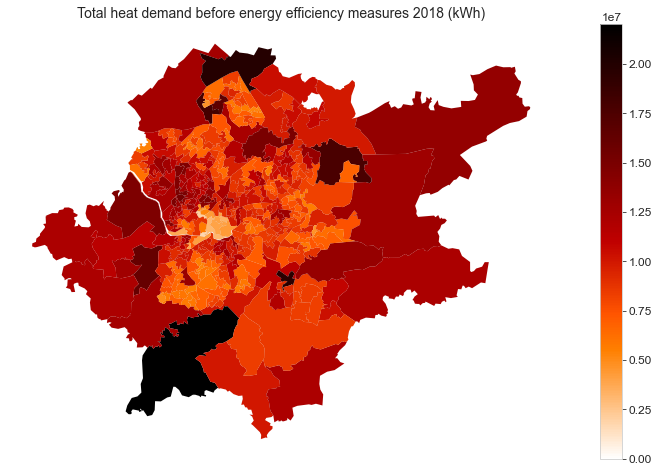

In [6]:
## Residential heat demand by LSOA
target = "Total heat demand before energy efficiency measures 2018 (kWh)"
path_map = r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\02 - NPT FLEXIS demo area\00 - Data\GIS map and data"
path_map = path_map+os.path.sep+"bristol.geojson"
f, ax = plt.subplots(figsize=figsize_map)

cmap_1 = 'gist_heat_r'
cbar = create_map(dataset1[['LSOA11CD', target]], target, path_map, f, ax, cmap=cmap_1, percentage_scale=False)
ax.set_title(target, fontsize= font_size+2)
f

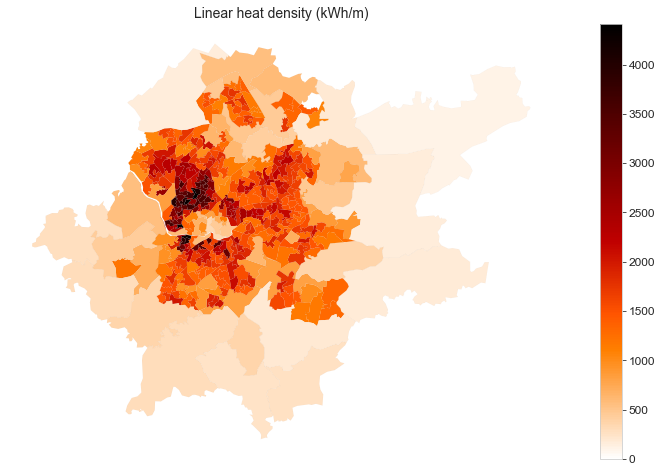

In [7]:
## Potential for district heating by LSOA in Bristol

dataset1["Linear heat density (kWh/m)"] = dataset1["Total heat demand before energy efficiency measures 2018 (kWh)"]/dataset1["Road length (m)"]
target = "Linear heat density (kWh/m)"

f, ax = plt.subplots(figsize=figsize_map)

cmap_1 = 'gist_heat_r'
cbar = create_map(dataset1[['LSOA11CD', target]], target, path_map, f, ax, cmap=cmap_1, percentage_scale=False)
ax.set_title(target, fontsize= font_size+2)
f

Text(0, 0.5, 'Number of units')

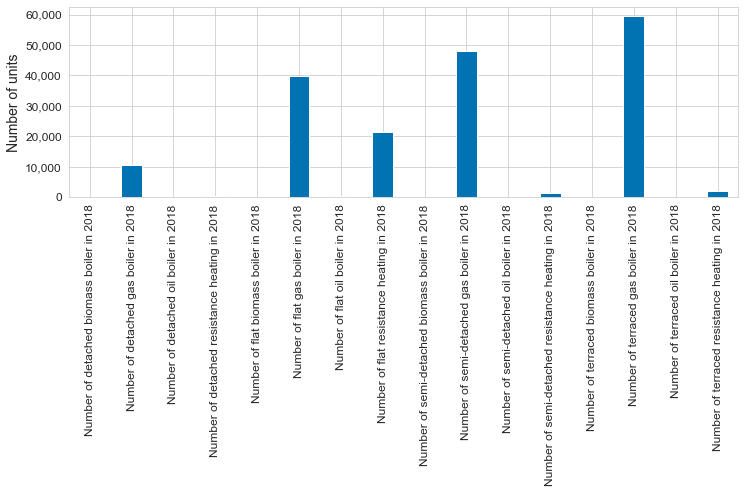

In [8]:
## Mainly dwellings using gas boilers in Bristol
number_units = [c for c in dataset1.columns if "Number" in c]

fig, ax = plt.subplots(figsize=figsize)
dataset1.loc[dataset1["Local Authority (2019)"]=='Bristol, City of', number_units].sum().plot.bar(ax=ax)
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
ax.set_ylabel("Number of units")

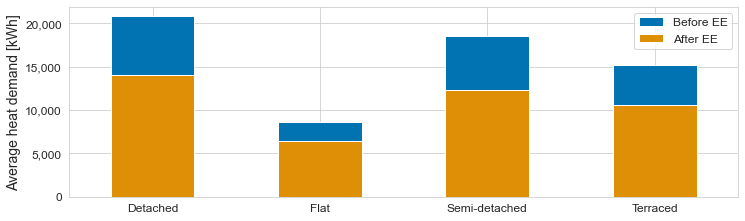

In [9]:
# Potential for heat demand savings for dwellings with gas boilers in Bristol

gas_boilers_before = [c for c in dataset1.columns if "gas boiler" in c and "before" in c]
gas_boilers_after = [c for c in dataset1.columns if "gas boiler" in c and "after" in c]
fig, ax = plt.subplots(figsize=figsize)
dataset1.loc[dataset1["Local Authority (2019)"]=='Bristol, City of', gas_boilers_before].mean().plot.bar(ax=ax, label="Before EE")

dataset1.loc[dataset1["Local Authority (2019)"]=='Bristol, City of', gas_boilers_after].mean().plot.bar(ax=ax, color=sns.color_palette()[1], label="After EE")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
ax.set_ylabel("Average heat demand [kWh]")
ax.set_xticklabels(["Detached", "Flat", "Semi-detached", "Terraced"], rotation = 0)
ax.legend()

The total cost is estimated at: 473 m£


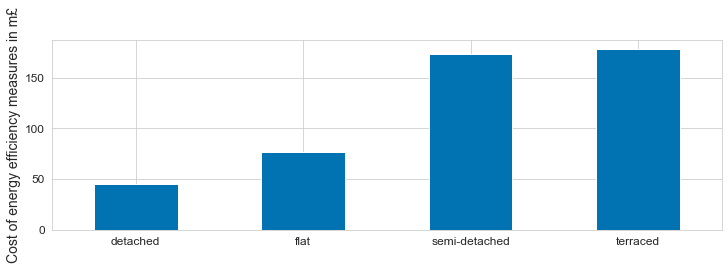

In [10]:
# How much would that cost? based on the number of each dwelling type in Bristol 
#and the average cost for each dwelling type to implement the energy efficiency measures.

dwelling_types = ["detached", "flat", "semi-detached", "terraced"]
costs_df = pd.DataFrame()
gas_boilers_cost = [c for c in dataset2.columns if "gas boiler (GBP)" in c]

for d in dwelling_types:
    cost_col = 'Average energy efficiency improvements costs of '+d+' gas boiler (GBP)'
    cost_val = dataset2.loc[dataset2["Local Authority (2019)"]=='Bristol, City of', cost_col].values[0]
    number_col = "Number of "+d+" gas boiler in 2018"
    number_val = dataset2.loc[dataset2["Local Authority (2019)"]=='Bristol, City of', number_col].values[0]
    
    costs_df.loc["Costs of energy efficiency measures (GBP)", d] =  cost_val*number_val
costs_df


fig, ax = plt.subplots(figsize=figsize)


(costs_df.T/1000000).plot.bar(ax=ax, rot=0)
ax.legend().remove()
ax.set_ylabel("Cost of energy efficiency measures in m£")
# ax.set_xticklabels(["Detached", "Flat", "Semi-detached", "Terraced"], rotation = 0)

print("The total cost is estimated at:", "{:,.0f} m£".format(costs_df.sum().sum()/1000000))

## Heat profiles of dwellings using gas boilers

In [11]:
#heat demand from gas boilers in Bristol

total_heat_demand_from_gas_boilers = 0
for d in dwelling_types:
    heat_col = 'Average heat demand before energy efficiency measures for '+d+' gas boiler (kWh)'
    heat_val = dataset1.loc[dataset1["Local Authority (2019)"]=='Bristol, City of', heat_col].mean()
    number_col = "Number of "+d+" gas boiler in 2018"
    number_val = dataset2.loc[dataset2["Local Authority (2019)"]=='Bristol, City of', number_col].values[0]
    total_heat_demand_from_gas_boilers = total_heat_demand_from_gas_boilers + heat_val*number_val
    print(d, heat_val, number_val)
    
print("Heat demand supplied by gas boilers:", "{:,.0f} MWh".format(total_heat_demand_from_gas_boilers/1000))

detached 20905.976386290462 10629.0
flat 8648.430849150604 39908.0
semi-detached 18561.09242980536 47940.0
terraced 15224.831414185506 59489.0
Heat demand supplied by gas boilers: 2,362,880 MWh


Text(0.5, 0, 'Date')

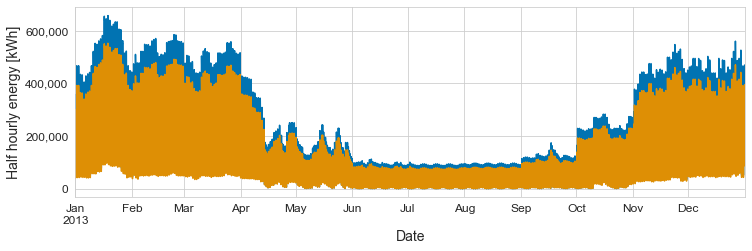

In [12]:
fig, ax = plt.subplots(figsize=figsize)
(total_heat_demand_from_gas_boilers*dataset3['Normalised_Gas_boiler_gas']).plot(ax=ax, label="Heat demand from gas boilers")
(total_heat_demand_from_gas_boilers*dataset3['Normalised_Gas_boiler_heat']).plot(ax=ax, label="Heat production from gas boilers")
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
ax.set_ylabel("Half hourly energy [kWh]")
ax.set_xlabel("Date")